In [14]:
### PREAMBLE
# Chapter 2 - linear models
# linear.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Chapter 2: Linear models

Before we dive into the discussion of adversarial attacks and defenses on deep networks, it is worthwhile considering the situation that arises when the hypothesis class is linear.  That is, for the multi-class setting $h_\theta : \mathbb{R}^n \rightarrow \mathbb{R}^k$, we consider a classifier of the form
\begin{equation}
h_\theta(x) = W x + b
\end{equation}
where $\theta = \{W \in \mathbb{R}^{k \times n}, b \in \mathbb{R}^k\}$.  We will also shortly consider a binary classifier of a slightly different form, as many of the ideas are a bit easer to describe in this setting, before returning back to the multi-class case.

Substituting this hypothesis back into our robust optimization framework, and also focusing on the case where the pertrubation set $\Delta$ is a norm ball $\Delta = \{\delta : \|\delta\| \leq \epsilon\}$, where we don't actually specify the type of norm, so this could be $\ell_\infty$, $\ell_2$, $\ell_1$, etc, we arrive at the mix-max problem
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_{W,b} \frac{1}{|D|} \sum_{x,y \in D} \max_{\|\delta\| \leq \epsilon}\ell(W(x+\delta) + b, y).
\end{equation}
The key point we will emphasize in this section, is that under this formulation, we can solve the inner maximization \emph{exactly} for the case of binary optimization, and provide a relatively tight upper bound for the case of multi-class classification.  Futhermore, because the resulting minimization problem is still convex in $\theta$ (we will see shortly that it remains convex even after maximizing over $\delta$, the resulting robust training procedure can _also_ be solved optimally, and thus we can achieve the globally optimal robust classifier (at least for the case of binary classification).  This is in stark constrast to the deep network case, where neither the inner maximization problem nor the outer minmimization problem can be solved globally (in the case of the outer minimization, this holds _even_ if we assume exact solutions of the inner problem, due to the non-convexity of the network itself).

However, understanding the linear case provides important insights into the theory and practice of adversarial robustness, and also provides connections to more commonly-studied methods in machine learning such as support vector machines.

## Binary classification

Let's begin first by considering the case of binary classification, i.e., k=2 in the multi-class setting we desribe above.  In this case, rather than use multi-class cross entropy loss, we'll be adopting the more common approach and using the binary cross entropy, or logistic loss.  In this setting, we have our hypothesis function
\begin{equation}
h_\theta(x) = w^T x + b
\end{equation}
for $\theta = \{w \in \mathbb{R}^n, b \in \mathbb{R}\}$, class label $y \in \{+1,-1\}$, and loss function
\begin{equation}
\ell(h_\theta(x), y) = \log(1+\exp(-y\cdot h_\theta(x))) \equiv L(y \cdot h_\theta(x))
\end{equation}
where for convience below we define the function $L(z) = \log(1+\exp(-z))$ which we will use below when discussing how to solve the optimization problems involving this loss.  The semantics of this setup are that for a data point $x$, the classifier predicts class $+1$ with probability
\begin{equation}
p(y=+1|x) = \frac{1}{1 + \exp(-h_\theta(x))}.
\end{equation}

**Aside:** Again, for those who may be unfamiliar with how this setting relates to the multiclass case we saw before, note that if we use the traditional mutlticlass cross entropy loss with two classes, of class 1 would be given by
\begin{equation}
\frac{\exp(h_\theta(x)_1)}{\exp(h_\theta(x)_1) + \exp(h_\theta(x)_2)} = 
\frac{1}{1 + \exp(h_\theta(x)_2 - h_\theta(x)_1)}
\end{equation}
and similarly the probaiblity of predicting class 2
\begin{equation}
\frac{\exp(h_\theta(x)_2)}{\exp(h_\theta(x)_1) + \exp(h_\theta(x)_2)} = 
\frac{1}{1 + \exp(h_\theta(x)_1 - h_\theta(x)_2)}.
\end{equation}
We can thus define a single scalar-valued hypothesis
\begin{equation}
h'_\theta(x) \equiv h_\theta(x)_1 - h_\theta(x)_2
\end{equation}
with the associated probabilities
\begin{equation}
p(y|x) = \frac{1}{1 + \exp(-y\cdot h'_\theta(x))}
\end{equation}
for $y$ defined as $y \in \{+1,-1\}$ as written above.  Taking the negative log of this quantity gives
\begin{equation}
-\log \frac{1}{1 + \exp(-y\cdot h'_\theta(x))} = \log(1 + \exp(-y\cdot h'_\theta(x)))
\end{equation}
which is exactly the logistic loss we define above.

### Solving the inner maximization problem

Now let's return to the robust optimization problem, and consider the inner maximization problem, which in this case takes the form
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(w^T (x+\delta), y) \equiv \maximize_{\|\delta\| \leq \epsilon} L(y \cdot (w^T(x+\delta) + b)).
\end{equation}
The key point we need to make here is that in this setting, it is actually possible to solve this inner maximization problem exactly.  To show this, first note the $L$ as we described it earlier is a scalar function that is monotonically decreasing, and looks like the following:

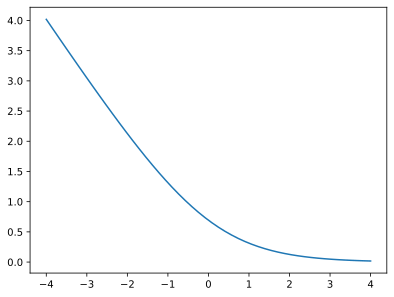

In [15]:
x = np.linspace(-4,4)
plt.plot(x, np.log(1+np.exp(-x)))

Because the function is monotoic decreasing, if we want to maximize this function applied to a scalar, that is equivalent to just minimizing the scalar quantity.  That is
\begin{equation}
\begin{split}
\DeclareMathOperator*{\minimize}{minimize}
\max_{\|\delta\| \leq \epsilon} L \left(y \cdot (w^T(x+\delta) + b) \right) & =
L\left( \min_{\|\delta\| \leq \epsilon}  y \cdot (w^T(x+\delta) + b) \right) \\
& = L\left(y\cdot(w^Tx + b) + \min_{\|\delta\| \leq \epsilon} y \cdot w^T\delta  \right)
\end{split}
\end{equation}
where we get the second line by just distributing out the linear terms.

So we need to consider how to solve the problem
\begin{equation}
\min_{\|\delta\| \leq \epsilon} y \cdot w^T\delta.
\end{equation}
To get the intuition here, let's just consider the case that $y = +1$, and consider an $\ell_\infty$ norm constraint $\|\delta\|_\infty \leq \epsilon$.  Since the $\ell_\infty$ norm says that each element in $\delta$ must have magnitude less than or equal $\epsilon$, we clearly minimize this quantity when we set $\delta_i = -\epsilon$ for $w_i \geq 0$ and $\delta_i = \epsilon$ for $w_i < 0$.  For $y = -1$, we would just flip these quantities.  That is, the optimal solution to the above optimization problem for the $\ell_\infty$ norm is given by
\begin{equation}
\delta^\star = - y \epsilon \cdot \mathrm{sign}(w)
\end{equation}

Furthermore, we can also determine the function valued achieved by this solution,
\begin{equation}
y \cdot w^T\delta^\star = y \cdot \sum_{i=1} -y \epsilon \cdot \mathrm{sign}(w_i) w_i = -y^2 \epsilon \sum_{i} |w_i| = -\epsilon \|w\|_1.
\end{equation}
Thus, we can actually _analytically_ compute the solution of the inner maximization problem, which just has the form
\begin{equation}
\max_{\|\delta\|_\infty \leq \epsilon} L \left(y \cdot (w^T(x+\delta) + b) \right) =
L \left(y \cdot (w^Tx + b) - \epsilon \|w\|_1 \right ).
\end{equation}
Therefore, instead of solving the robust min-max problem as an actual min-max problem, we have been able to convert it to a pure minimization problem, given by
\begin{equation}
\minimize_{w,b} \frac{1}{D} \sum_{(x,y) \in D} L \left(y \cdot (w^Tx + b) - \epsilon \|w\|_1 \right ).
\end{equation}
This problem is still convex in $w,b$, so can be solved exactly, or e.g., SGD will also approach the globally optimal solution.  A little more generally, it turns out that in general the optimization problem 
\begin{equation}
\min_{\|\delta\| \leq \epsilon} y \cdot w^T\delta = -\epsilon \|w\|_*
\end{equation}
where $\|\cdot\|_*$ denotes the the dual norm of our original norm bound on $\theta$ ($\|\cdot\|_p$ and $\|\cdot\|_q$ are dual norms for $1/p + 1/q = 1$).  So regardless of our norm constraint, we can actually solve the robust optimization problem via a single minimization problem (and find the analytical solution to the worse-case adversarial attack), without the need to explicitly solve a min-max problem.

Note that the final robust optimization problem (now adopting the general form),
\begin{equation}
\minimize_{w,b} \frac{1}{D}\sum_{(x,y) \in D} L \left(y \cdot (w^Tx + b) - \epsilon \|w\|_* \right )
\end{equation}
looks an awful lot like the typical norm-regularized objective we commonly consider in machine learning
\begin{equation}
\minimize_{w,b} \frac{1}{D}\sum_{(x,y) \in D} L (y \cdot (w^Tx + b)) + \epsilon \|w\|_*
\end{equation}
with the except that the regularization term is _inside_ the loss function.  Intuitively, this means that in the robust optimization case, if a point is far from the decision boundary, we _don't_ penalize the norm of the parameters, but we _do_ penalize the norm of the parameters (transformed by the loss function) for a point where we close to the decision boundary.  The connections between such formulations and e.g. support vector machines, has been studied extensively [\cite XuMannor].

### Illustration of binary classification setting

Let's see what this looks like for an actual linear classifier.  In doing so, we can also get a sense of how well traditional linear models might work to also prevent adversarial examples (spoiler: not very well, unless you do regularize).  To do so, we're going to consider the MNIST data set, which will actually serve as a running example for the vast majority of the rest of this tutorial.  MNIST is actually a fairly poor choice of problem for many reasons: in addition to being very small for modern ML, it also has the property that it can easily be "binarized", i.e., because the pixel values are essentially just black and white, we can remove more $\ell_\infty$ noise by just rounding to 0 or 1, and the classifying the resulting iamge.  But presuming we _don't_ use such strategies, it is still a reasonable choice for initial experiments, and small enough that some of the more complex methods we discuss in further sections still can be run in a reasonable amount of time.

Since we're in the binary classification setting for now, let's focus on the even easier problem of just classifying between 0s and 1s in the MNIST data (we'll return back to the multi-class setting for linear models shortly).  Let's first load the data using the PyTorch library and build a simple linear classifier using gradient descent.  Note that we're going to do this a bit more explicitly to replicate the logic above (i.e., using labels of +1/-1, using the direct computation of the $L$ function, etc) instead of reverse-engineering it from the typical PyTorch functions.

Let's first load the MNIST data reduced to the 0/1 examples.

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
#print(mnist_train.train_data[1])
train_idx = mnist_train.train_labels <= 1
print(train_idx.shape)
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

test_idx = mnist_test.test_labels <= 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

torch.Size([60000])


Now let's build a simple linear classifier (the `nn.Linear` module does this, containing the weights in the `.weight` object and the bias in the `.bias` object).  The `nn.Softplus` function implement $L$ function above (though without negating the input), and does so in a more numerically stable way than using the exp or log functions directly.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# do a single pass over the data
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

We'll train the classifier for 10 epochs, though note that MNIST 0/1 binary classification is a _very_ easy problem, and after one epoch we basically have converged to the final test error (though test loss still decreases).  It eventually reaches as error of 0.0004, which in this case actually just making one mistake on the test set.

In [18]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.005922	0.015210	0.000946	0.003314
0.001500	0.005410	0.000473	0.002566
0.001263	0.004475	0.000473	0.002333
0.001105	0.003854	0.000473	0.002269
0.001026	0.003519	0.000946	0.002097
0.000947	0.003264	0.000473	0.002047
0.000711	0.002922	0.000473	0.001980
0.000790	0.002795	0.000473	0.002057
0.000790	0.002643	0.000946	0.001941
0.000711	0.002410	0.000473	0.002058


In case you're curious, we can actually look at the one test example that the classifier makes a mistake on, which indeed seems a bit odd relative to most 0s and 1s.

Text(0.5, 1.0, 'True Label: 0')

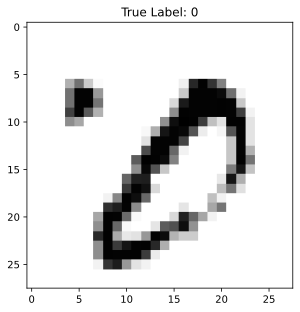

In [19]:
X_test = (test_loader.dataset.test_data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.test_labels
yp = model(X_test)[:,0]
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)
plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[idx].item()))

Hopefully you've already noticed something else about the adversarial examples we generate in the linear case: because the optimal perturbation is equal to
\begin{equation}
\delta^\star = - y \epsilon \cdot \mathrm{sign}(w),
\end{equation}
which doesn't depend on $x$, this means that the best perturbation to apply is the _same_ across all examples.  Note however, that to get the best valid perturbation, here we should really be constraining $x + \delta$ to be in $[0,1]$, which _doesn't_ hold for this case.  For simplicity, we'll ignore this for now, and go ahead and add this same $\delta$ anyway (even if it gives us a technically invalid image).  After all, for the classifier, the inputs are just numerical value, so we can always have values greater than one or less than zero; the performance we'll see also applies to the case where we clip values, it just adds a bit of uncecessary hassle.

Let's look at the actual perturvation, to try to get a dense of it.

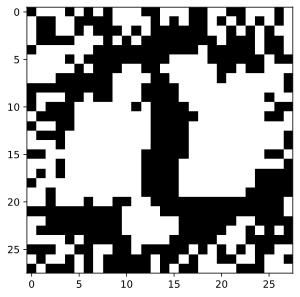

In [7]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

It's perhaps not all that obvious, but if you squint you can see that maybe there is a vertical line (like a 1) in black pixels, and a cirlce (like a 0) in in white.  The intuition here is that moving in the black direction, we make the classifier think the image is more like a 1, while moving in the white direction, more like a 0.  But the picture here is not perfect, and it you didn't know to look for this, it may not be obviously.  We'll shortly 

Let's next see what happens when we evaluate the test accuracy when we make this (optimal) adverarial attack on the images in the test set.

In [8]:
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.8349881796690307, 3.1657466460063386)


So allowing perturbations within the $\ell_\infty$ ball of size $\epsilon=0.2$, the classifier we go from essentially zero error to 84.5% error.  Unlike the ImageNet case, the perturbed images here, _are_ recognizably different (we just overlay the noise you saw above), but this would definitely note be sufficient to fool most humans in recognizing the image.

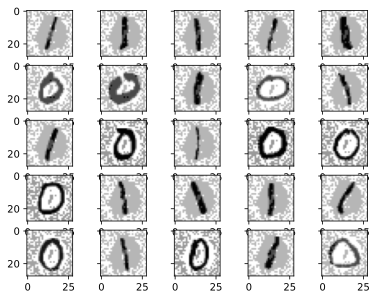

In [20]:
f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax

### Training robust linear models

We've now seen that a standard linear model suffers from a lot of the same problems as deep models (though it should be said, they are still slightly more resilient than standard training for deep networks, for which an $\ell_\infty$ ball with $\epsilon=0.2$ could easily create 100% error).  But we also know that we can easily perform exact robust optimization (i.e., solving the equivalent of the min-max problem) by simply incorporating the $\ell_1$ norm into the objective.  Putting this into the standard binary cross entropy loss that PyTorch implements (which uses labels of 0/1 by default, not -1/+1), takes a bit of munging, but the training procedure is still quite simple: we just subtract $\epsilon(2y-1)\|w\|_1$ from the predictions (the $2y-1$ scales the 0/1 entries to -1/+1).

In [21]:
# do a single pass over the data
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [11]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.149546	0.376543	0.062884	0.205697
0.073115	0.222993	0.044917	0.162505
0.062061	0.196968	0.047754	0.162878
0.057165	0.183363	0.038771	0.140833
0.053060	0.174056	0.039243	0.140228
0.049507	0.167750	0.039716	0.137977
0.048006	0.162645	0.034515	0.124956
0.045795	0.158116	0.030733	0.118352
0.044611	0.154542	0.033570	0.123116
0.042163	0.151662	0.034988	0.126415
0.041690	0.149138	0.028842	0.119779
0.040347	0.147109	0.026950	0.107728
0.039005	0.144856	0.026478	0.105634
0.038058	0.143152	0.026950	0.107023
0.037505	0.141419	0.027896	0.109285
0.036952	0.140268	0.025059	0.102406
0.036163	0.139051	0.025059	0.103223
0.035610	0.137926	0.025059	0.107297
0.034899	0.136847	0.024586	0.100058
0.034268	0.136178	0.026478	0.114099


We stay it above, but we should emphasize that all the numbers reported above are the _robust_ (i.e., worst case adversarial) errors and losses.  So by training with the robust optimization problem, we're able to train a model such that for $\epsilon=0.2$, no adversarial attack can lead to more then 2.5% error on the test set.  Quite an improvement from the ~85% that the standard training had.  But how well does it do on the _non-adversarial_ training set?

In [22]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.000711	0.002448	0.000473	0.002058


We're getting 0.3% error on the test set.  This is good, but _not_ as good as we were doing with standard training; we're now making 8 mistakes on the test set, instead of the 1 that we were making before.  And this is not just a random effect of this particular problem, or the fact that it is relatively easy.  Rather, perhaps somewhat surprisingly, there is a _fundamental_ tradeoff between clean accuracy and robust accuracy, and doing better on the robust error leads to higher clean error.  We will return to this point in much more detail later.

Finally, let's look at the image of the optimal perturbation for this robust model.

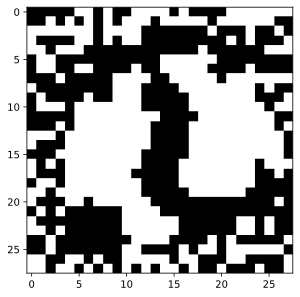

In [23]:
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

That looks substantially more like a zero than what we saw before.  Thus, we have some (admittedly, at this point, fairly weak) evidence that robsut training may also lead to "adversarial directions" that are inherrently more meaningful.  Rather than fooling the classifier by just adding "random noise" we actually need to start moving the image in the direction of an actual new image (and even doing so, at least with this size epsilon, we aren't very successful at fooling the classifier).  This idea will also come up later.

## Multi-class classification

Before moving on to the deep learning setting, let's briefly consider the multi-class extension of what we presented above.  After all, most deep classifiers that we care about are actually multi-class classifiers, using the cross entropy loss or something similar.  Recalling what we defined before, this means we are considering the linear hypothesis function
\begin{equation}
h_\theta(x) = W x + b
\end{equation}
which results in an inner maximization problem of the form
\begin{equation}
\max_{\|\delta\| \leq \epsilon}\ell(W(x+\delta) + b, y).
\end{equation}
Unforutnately in the binary case, it turns out that it is no longer possible to optimally solve the inner maximization problem.  Specifcally, if we consider the cross entropy loss plugged into the above expression
\begin{equation}
\max_{\|\delta\| \leq \epsilon} \left (\log \left ( \sum_{j=1}^k \exp(w_j^T (x + \delta) + b_i) \right ) - (w_y^T(x + \delta) + b_y) \right ).
\end{equation}
Here, unlike the binary case, we cannot push the max over $\delta$ inside the nonlinear function (the log-sum-exp function is convex, so maximizing over it is difficult in general).

